# Notebook dedicated to Fit the $\alpha$-n Dt and Dr High_stat. Data to Exponential and Gaussian Distributions

In [1]:
import numpy as np
import pandas as pd
from scipy.special import factorial
import uproot

import matplotlib.pyplot as plt
import seaborn as sn

from lmfit import Model
from scipy.optimize import curve_fit

# 1 - Import Data

In [2]:
data = pd.read_csv('data/Dr_Dt_0.8MeV_5500mm.csv')
Dt = data['Dt (mcs)']
Dr = data['Dr (mm)']

# 2 - Define Fit Functions

## 2.1 - Exponential

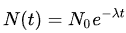

In [3]:
def fit_exp(x, n0, lambda_):
    return n0 * np.exp(lambda_ * x)

## 2.2 - Gaussian

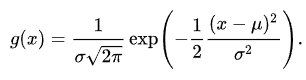

In [4]:
def fit_gauss(x, sigma, mu):
    # mu -> Mean value
    #sigma -> Standard deviation
    a = 1/(sigma * np.sqrt(2*np.pi))
    return a * np.exp((-1/2) * ((x - mu)**2) / (sigma**2))

## 2.3 - Poisson

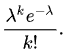

In [5]:
def fit_poisson(x, lambda_):
    #lambda_ -> Expected value(x) = Variance(x)
    return lambda_**(x) * np.exp(lambda_) * (1/factorial(x.astype('int')))

# 3 -  Fit procedure

## 3.1 - Extract Data Points

In [37]:
Dr_sup_lim = 700
Dr_inf_lim = 50

Dr_cut = np.array(Dr[(Dr < Dr_sup_lim) & (Dr >= Dr_inf_lim)])

bins_t = 50
bins_r = 15

counts_t, bins_edge_t = np.histogram(Dt, bins = bins_t)
counts_r, bins_edge_r = np.histogram(Dr_cut, bins = bins_r, density = True)

#Counts are y-axis values and bins_center are x_axis values
bins_center_t = (bins_edge_t[:-1] + bins_edge_t[1:]) / 2
bins_center_t = np.round(bins_center_t, decimals = 2)

bins_center_r = (bins_edge_r[:-1] + bins_edge_r[1:]) / 2
bins_center_r = np.round(bins_center_r, decimals = 2)

## 3.2 - Perform the fit

### 3.2.1 - Dt Fit

In [34]:
y_t = counts_t
x_t = bins_center_t

fit_model_dt = Model(fit_exp)
result_dt = fit_model_dt.fit(y_t, x = x_t, n0 = 1, lambda_ = 1/150)

n0 = result_dt.best_values['n0']
lambda_ = result_dt.best_values['lambda_']

lambda_err = result_dt.params['lambda_'].stderr
n0_err = result_dt.params['n0'].stderr

tau = -1/lambda_
tau_err = lambda_err/(lambda_**2)  #error propagation
tau 

print(result_dt.fit_report())

[[Model]]
    Model(fit_exp)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 52
    # data points      = 50
    # variables        = 2
    chi-square         = 4708.77400
    reduced chi-square = 98.0994584
    Akaike info crit   = 231.257993
    Bayesian info crit = 235.082039
    R-squared          = 0.99924571
[[Variables]]
    n0:       1639.32789 +/- 8.02775633 (0.49%) (init = 1)
    lambda_: -0.00467039 +/- 3.2140e-05 (0.69%) (init = 0.006666667)
[[Correlations]] (unreported correlations are < 0.100)
    C(n0, lambda_) = -0.7144


### 3.2.1 - Dr Fit

#### * Graussina Fit

In [38]:
y_r = counts_r
x_r = bins_center_r

fit_model_dr_gauss = Model(fit_gauss)
result_dr_gauss = fit_model_dr_gauss.fit(y_r, x = x_r, sigma = np.std(Dr_cut), mu = np.mean(Dr_cut))

sigma_op_gauss = result_dr_gauss.best_values['sigma']
mu_op_gauss = result_dr_gauss.best_values['mu']

mu_err_gauss = result_dr_gauss.params['mu'].stderr

print(result_dr_gauss.fit_report())

[[Model]]
    Model(fit_gauss)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 15
    # variables        = 2
    chi-square         = 5.7858e-07
    reduced chi-square = 4.4506e-08
    Akaike info crit   = -252.061155
    Bayesian info crit = -250.645055
    R-squared          = 0.87749996
[[Variables]]
    sigma:  182.445451 +/- 8.13132758 (4.46%) (init = 154.9866)
    mu:     391.675926 +/- 9.59546932 (2.45%) (init = 392.3162)


# 4 - Plots

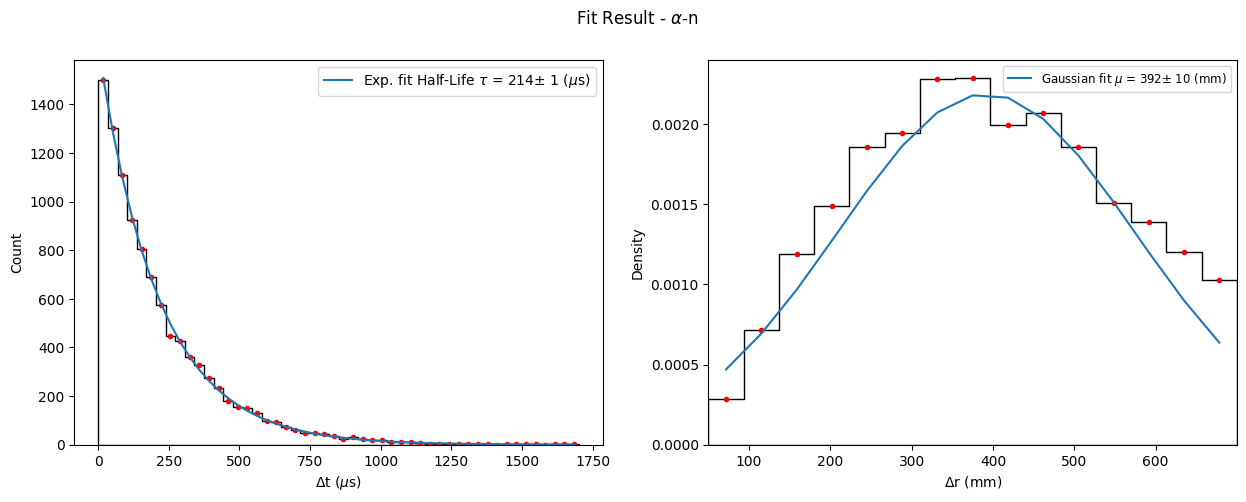

In [40]:
save = False

fig, axes = plt.subplots(1, 2,  figsize=(15, 5))

sn.histplot(Dt, bins = bins_t, ax = axes[0], color = 'black', alpha = 0.0, element = 'step')
axes[0].scatter(x = bins_center_t, y = counts_t, color = 'r', marker='.')
axes[0].plot(x_t, result_dt.best_fit, label = rf'Exp. fit Half-Life $\tau$ = {tau:.0f}$\pm$ {tau_err:.0f} ($\mu$s)')

sn.histplot(Dr_cut, bins = bins_r, ax = axes[1], color = 'black', alpha = 0.0, element = 'step', stat = 'density')
axes[1].scatter(x = bins_center_r, y = counts_r, color = 'r', marker='.')
axes[1].plot(x_r, result_dr_gauss.best_fit, label = rf'Gaussian fit $\mu$ = {mu_op_gauss:.0f}$\pm$ {mu_err_gauss:.0f} (mm)')


axes[0].legend(loc= 'upper right', fontsize = 10)
axes[0].set_xlabel(r'$\Delta$t ($\mu$s)')

axes[1].legend(loc= 'upper right', fontsize = 8.5)
axes[1].set_xlabel(r'$\Delta$r (mm)')
axes[1].set_xlim(min(Dr_cut), max(Dr_cut))

plt.suptitle(r'Fit Result - $\alpha$-n')

if save:
    plt.savefig('figs/Fit_Dt_Dr.png', format='png', bbox_inches = 'tight')

plt.show()